# Import relevant packages

In [ ]:
import numpy as np
from   scipy.ndimage.filters import laplace
from   scipy.ndimage import uniform_filter, gaussian_filter
import os
import nrrd
import pandas as pd
import glob
import matplotlib.pyplot as plt
import matplotlib.figure 
import imageio
import time
import vtk
import h5py
import cv2
import csv
import re
from numpy import genfromtxt
from   IPython.display import Image
from vtk.util.numpy_support import vtk_to_numpy
import nibabel as nib
import matplotlib.image as mpimg
from __future__ import print_function
import scipy.misc
from PIL import Image
from scipy.ndimage import zoom
from scipy.ndimage import rotate
import itertools
from cv2.ximgproc import guidedFilter
from sporco.util import tikhonov_filter
import torch
import torch.nn
from torch.autograd import Variable
from torchvision.models.vgg import vgg19
from  skimage import color
import imageio

## Import cropped 3D MRI volume based on the steps provided in the ReadMe documentation

In [ ]:
img = nib.load('./Data/2017_43/cropped_cylinder_volume_new1.nii')

In [ ]:
data = img.get_data()

In [ ]:
np.max(data)

686.0

# Rendering code for tumor not visible on the cortical surface

In [ ]:
filenameSegmentation = "./Data/cropped_cylinder_volume_new1.nii"
reader = vtk.vtkNIFTIImageReader()
reader.SetFileName(filenameSegmentation)

castFilter = vtk.vtkImageCast()
castFilter.SetInputConnection(reader.GetOutputPort())
castFilter.SetOutputScalarTypeToUnsignedShort()
castFilter.Update()

imdataBrainSeg = castFilter.GetOutput()

#opacity and MIP are the critical transfer functions for tumor segmentation
opacityTransferFunction = vtk.vtkPiecewiseFunction()
opacityTransferFunction.AddPoint(0.0, 0.0)
opacityTransferFunction.AddPoint(452, 0.4)
opacityTransferFunction.AddPoint(686, 1.0)


funcOpacityGradient = vtk.vtkPiecewiseFunction()
funcOpacityGradient.AddPoint(0.0,   1.0)
funcOpacityGradient.AddPoint(686.0,   1.0)

colorTransferFunction = vtk.vtkColorTransferFunction()
colorTransferFunction.AddRGBPoint(0.0, 0.25, 0.25, 0.25)
colorTransferFunction.AddRGBPoint(115, 0.25, 0.25, 0.25)
colorTransferFunction.AddRGBPoint(231, 0.5, 0.5, 0.5)
colorTransferFunction.AddRGBPoint(346, 0.75, 0.75, 0.75)
colorTransferFunction.AddRGBPoint(460, 1.0, 1.0, 1.0)
colorTransferFunction.AddRGBPoint(686, 1.0, 1.0, 1.0)

volumeProperty = vtk.vtkVolumeProperty()
volumeProperty.SetColor(colorTransferFunction)
volumeProperty.SetScalarOpacity(opacityTransferFunction)
volumeProperty.SetGradientOpacity(funcOpacityGradient)
volumeProperty.ShadeOn()
volumeProperty.SetAmbient(0.3)
volumeProperty.SetDiffuse(0.6)
volumeProperty.SetSpecular(0.5)
volumeProperty.SetSpecularPower(40.0)
volumeProperty.SetInterpolationTypeToLinear() 

volumeMapper = vtk.vtkGPUVolumeRayCastMapper()
#volumeMapper.SetBlendModeToMaximumIntensity()
volumeMapper.SetInputConnection(reader.GetOutputPort())

volume = vtk.vtkVolume()
volume.SetMapper(volumeMapper)
volume.SetProperty(volumeProperty)

renderer = vtk.vtkRenderer()
renderer.SetBackground(1,1,1)
renderer.AddVolume(volume)

renderWin = vtk.vtkRenderWindow()
renderWin.SetOffScreenRendering(1)


renderWin.AddRenderer(renderer)
renderWin.SetSize(450, 380)
renderer.ResetCamera()
renderer.GetActiveCamera
renderer.GetActiveCamera().Zoom(3)
renderer.GetActiveCamera().Roll(20)
renderer.GetActiveCamera().Azimuth(75)
renderer.GetActiveCamera().Elevation(-5)
renderWin.Render()

windowToImageFilter = vtk.vtkWindowToImageFilter()
windowToImageFilter.SetInput(renderWin)
windowToImageFilter.Update()
     
vtk_image = windowToImageFilter.GetOutput()
width, height, _ = vtk_image.GetDimensions()
vtk_array = vtk_image.GetPointData().GetScalars()
components = vtk_array.GetNumberOfComponents()
arr = vtk_to_numpy(vtk_array).reshape(height, width, components)
arr = arr[:,:,0].T

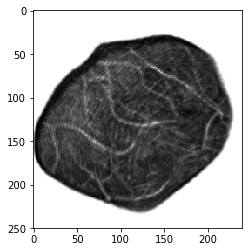

In [ ]:
arr = arr[0:250,0:240]
width, height = arr.shape
arr = arr.astype(float)
arr = (arr - np.min(arr)) / (np.max(arr) - np.min(arr))
plt.imshow(arr,'gray')

# Rendering code for tumor visible on the cortical surface

In [ ]:
filenameSegmentation = "./Data/cropped_cylinder_volume_new1.nii"
reader = vtk.vtkNIFTIImageReader()
reader.SetFileName(filenameSegmentation)

castFilter = vtk.vtkImageCast()
castFilter.SetInputConnection(reader.GetOutputPort())
castFilter.SetOutputScalarTypeToUnsignedShort()
castFilter.Update()

imdataBrainSeg = castFilter.GetOutput()

#opacity and MIP are the critical transfer functions for tumor segmentation
opacityTransferFunction = vtk.vtkPiecewiseFunction()
opacityTransferFunction.AddPoint(0.0, 0.0)
opacityTransferFunction.AddPoint(452, 0.4)
opacityTransferFunction.AddPoint(686, 1.0)


funcOpacityGradient = vtk.vtkPiecewiseFunction()
funcOpacityGradient.AddPoint(0.0,   1.0)
funcOpacityGradient.AddPoint(686.0,   1.0)

colorTransferFunction = vtk.vtkColorTransferFunction()
colorTransferFunction.AddRGBPoint(0.0, 0.25, 0.25, 0.25)
colorTransferFunction.AddRGBPoint(115, 0.25, 0.25, 0.25)
colorTransferFunction.AddRGBPoint(231, 0.5, 0.5, 0.5)
colorTransferFunction.AddRGBPoint(346, 0.75, 0.75, 0.75)
colorTransferFunction.AddRGBPoint(460, 1.0, 1.0, 1.0)
colorTransferFunction.AddRGBPoint(686, 1.0, 1.0, 1.0)

volumeProperty = vtk.vtkVolumeProperty()
volumeProperty.SetColor(colorTransferFunction)
volumeProperty.SetScalarOpacity(opacityTransferFunction)
volumeProperty.SetGradientOpacity(funcOpacityGradient)
volumeProperty.ShadeOn()
volumeProperty.SetAmbient(0.3)
volumeProperty.SetDiffuse(0.6)
volumeProperty.SetSpecular(0.5)
volumeProperty.SetSpecularPower(40.0)
volumeProperty.SetInterpolationTypeToLinear() 

volumeMapper = vtk.vtkGPUVolumeRayCastMapper()
volumeMapper.SetBlendModeToMaximumIntensity()
volumeMapper.SetInputConnection(reader.GetOutputPort())

volume = vtk.vtkVolume()
volume.SetMapper(volumeMapper)
volume.SetProperty(volumeProperty)

renderer_ = vtk.vtkRenderer()
renderer_.SetBackground(1,1,1)
renderer_.AddVolume(volume)

renderWin_ = vtk.vtkRenderWindow()
renderWin_.SetOffScreenRendering(1)

renderWin_.AddRenderer(renderer_)
renderWin_.SetSize(450, 380)
renderer_.ResetCamera()
renderer_.GetActiveCamera
renderer_.GetActiveCamera().Zoom(3)
renderer_.GetActiveCamera().Roll(20)
renderer_.GetActiveCamera().Azimuth(75)
renderer_.GetActiveCamera().Elevation(-5)
renderWin_.Render()

windowToImageFilter = vtk.vtkWindowToImageFilter()
windowToImageFilter.SetInput(renderWin_)
windowToImageFilter.Update()
     
vtk_image_ = windowToImageFilter.GetOutput()
width, height, _ = vtk_image_.GetDimensions()
vtk_array_ = vtk_image_.GetPointData().GetScalars()
components = vtk_array_.GetNumberOfComponents()
arr_ = vtk_to_numpy(vtk_array_).reshape(height, width, components)
arr_  = arr_[:,:,0].T

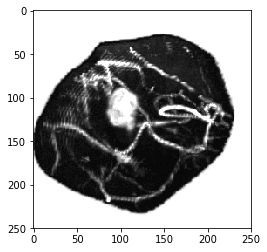

In [ ]:
arr_ = arr_[0:250,0:250]
width, height = arr_.shape
arr_ = arr_.astype(float)
arr_ = (arr_ - np.min(arr_)) / (np.max(arr_) - np.min(arr_))
plt.imshow(arr_,'gray')

 # Load the thermal image after registrating it with rendered and cropped MRI image of cortical surface based on the landmark registration using 3D Slicer tool

In [ ]:
img = Image.open('./Data/Thermo.png')
background = Image.new("RGB", img.size, (255, 255, 255))
background.paste(img, mask=img.split()[3])
background.save('thermo.png', 'PNG', quality=100)
img = Image.open('thermo.png')
img.resize((height,width)).save('thermo.png')
img_ = mpimg.imread('thermo.png')

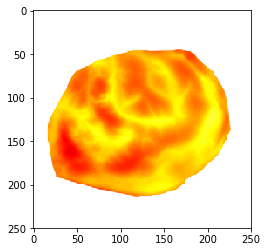

In [ ]:
plt.imshow(img_,'gray')

In [ ]:
img_.shape

(250, 250, 3)

In [ ]:
im = Image.open('./Data/Optical.png')
im.load()
background = Image.new("RGB", im.size, (255, 255, 255))
background.paste(im, mask=im.split()[3])
background.save('optical.png', 'PNG', quality=100)
im = Image.open('optical.png')
im.resize((height,width)).save('optical.png')
im_ = mpimg.imread('optical.png')

# Register thermal image with optical image by performing mirroring and then landmark registration using 3D Slicer

In [ ]:
im_ = mpimg.imread('optical.png')
alpha1 = 0.0             # Original value is black
alpha = np.ones((width,height),dtype=float)
r2, g2, b2 = 1.0,1.0,1.0 #replace with white
red, green, blue = im_[:,:,0], im_[:,:,1], im_[:,:,2]
mask = (im_[:,:,0]== alpha1)
im_[:,:,:3][mask] = [r2, g2, b2]

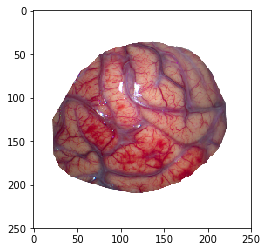

In [ ]:
plt.imshow(im_,'gray')

In [ ]:
im_.shape

(250, 250, 3)

# Visualise the MR, thermal and RGB images together

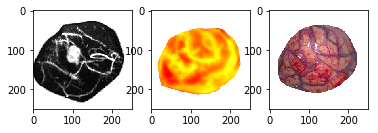

In [ ]:
fig, ax = plt.subplots(1,3)
ax[0].imshow(arr_,'gray')
ax[1].imshow(img_)
ax[2].imshow(im_)

In [ ]:
mri = color.gray2rgb(arr_)
mri_notumor = color.gray2rgb(arr)
thermo = img_
optical = im_

# Perform fusion of MR and Thermal image

In [ ]:
#define activation function
def get_activation(model, layer_numbers, input_image):
    outs = []
    out = input_image
    for i in range(max(layer_numbers)+1):
        with torch.no_grad():
            out = model.features[i](out)
        if i in layer_numbers:
            outs.append(np.rollaxis(out.detach().cpu().numpy()[0], 0, 3))
    return outs

def mip_features(out):
    h, w, d = out.shape
    A_temp = np.zeros((h+2, w+2))
    max_= np.max(out,axis=2)
    A_temp[1:h+1, 1:w+1] = abs(max_)
    return A_temp

def fusion_strategy(feat_a, feat_b, source_a, source_b, unit):
    m, n = feat_a.shape
    m1, n1 = source_a.shape[:2]
    weight_ave_temp1 = np.zeros((m1, n1))
    weight_ave_temp2 = np.zeros((m1, n1))
    for i in range(1, m):
        for j in range(1, n):        
            weight_ave_temp1[(i-2)*unit+1:(i-1)*unit+1, (j-2)*unit+1:(j-1)*unit+1] = feat_a[i-1,j-1] / (feat_a[i-1,j-1] + feat_b[i-1,j-1])
            weight_ave_temp2[(i-2)*unit+1:(i-1)*unit+1, (j-2)*unit+1:(j-1)*unit+1] = feat_b[i-1,j-1] / (feat_a[i-1,j-1] + feat_b[i-1,j-1])
              
    if source_a.ndim == 3:
        weight_ave_temp1 = weight_ave_temp1[:, :, None]
    source_a_fuse = source_a * weight_ave_temp1
    if source_b.ndim == 3:
        weight_ave_temp2 = weight_ave_temp2[:, :, None]
    source_b_fuse = source_b * weight_ave_temp2
    if source_a.ndim == 3 or source_b.ndim == 3:
        gen = np.atleast_3d(source_a_fuse) + np.atleast_3d(source_b_fuse)
    else:
        gen = source_a_fuse + source_b_fuse
    
    return gen

In [ ]:
s3          = np.dstack([mri])
grayhigh3   = np.rollaxis(s3, 2, 0)[None, :, :, :]
s3          = np.dstack([thermo])
irhigh3     = np.rollaxis(s3, 2, 0)[None, :, :, :]
s3          = np.dstack([optical])
opthigh3     = np.rollaxis(s3, 2, 0)[None, :, :, :]

In [ ]:
model = vgg19(True).cuda().eval()

In [ ]:
gray_in = torch.from_numpy(grayhigh3).cuda()
gray_in = gray_in.float()

In [ ]:
ir_in = torch.from_numpy(irhigh3).cuda()
ir_in = ir_in.float()

In [ ]:
opt_in = torch.from_numpy(opthigh3).cuda()
opt_in = opt_in.float()

In [ ]:
relus = [2, 7, 12, 21]
unit_relus = [1, 2, 4, 8]

In [ ]:
relus_gray = get_activation(model, relus, gray_in)
relus_ir   = get_activation(model, relus, ir_in)
relus_opt   = get_activation(model, relus, opt_in)

In [ ]:
gray_feats = [mip_features(out) for out in relus_gray]
ir_feats = [mip_features(out) for out in relus_ir]
opt_feats = [mip_features(out) for out in relus_opt]

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python2.7/dist-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)


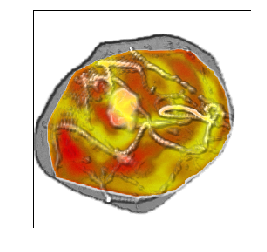

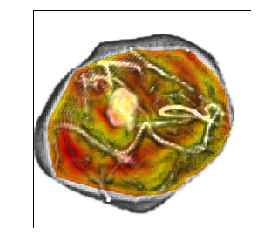

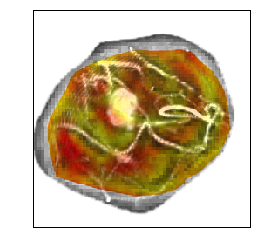

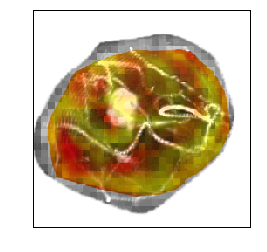

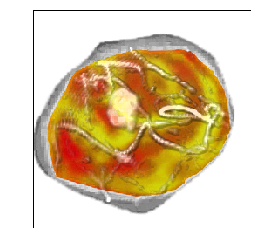

In [ ]:
saliencies = []
saliency_max = None
for idx in range(len(relus)):
    saliency_current = fusion_strategy(gray_feats[idx], ir_feats[idx], mri, thermo, unit_relus[idx])
    saliencies.append(saliency_current)
    
    if saliency_max is None:
        saliency_max = saliency_current
    else:
        saliency_max = np.maximum(saliency_max, saliency_current)
    
    plt.imshow(saliency_current)
    plt.axis('off')
    plt.show()

plt.imshow(saliency_max)
plt.axis('off')
plt.show()

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars


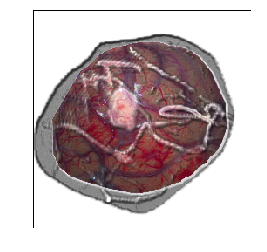

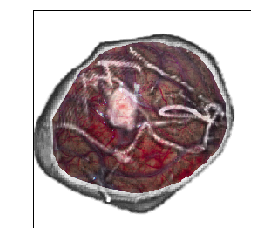

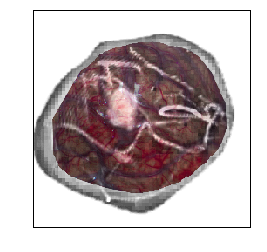

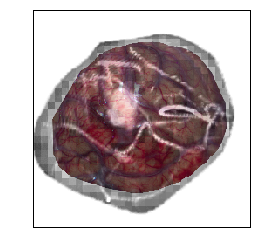

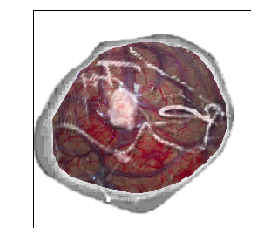

In [ ]:
saliencies_opt = []
saliency_max_opt = None
for idx in range(len(relus)):
    saliency_current_opt = fusion_strategy(gray_feats[idx], opt_feats[idx], mri, optical, unit_relus[idx])
    #saliency_max_opt.append(saliency_current_opt)
    
    if saliency_max_opt is None:
        saliency_max_opt = saliency_current_opt
    else:
        saliency_max_opt = np.maximum(saliency_max_opt, saliency_current_opt)
    
    plt.imshow(saliency_current_opt)
    plt.axis('off')
    plt.show()

plt.imshow(saliency_max_opt)
plt.axis('off')
plt.show()

In [ ]:
fusion_thermal = saliency_max
fusion_opt = saliency_max_opt

Text(0.5,1,'Fusion_opt')

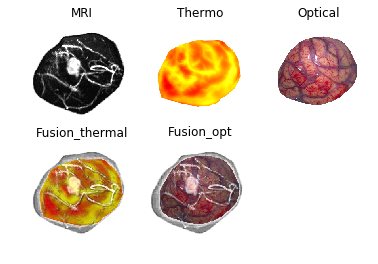

In [ ]:
gs1= matplotlib.figure.Figure(figsize=(15, 10),frameon=False)
plt.subplot(2,3, 1)
plt.imshow(mri,'gray')
plt.axis('off')
plt.title('MRI')

plt.subplot(2, 3, 2)
plt.imshow(thermo)
plt.axis('off')
plt.title('Thermo')

plt.subplot(2,3, 3)
plt.imshow(optical)
plt.axis('off')
plt.title('Optical')

plt.subplot(2, 3, 4)
fig.tight_layout()
plt.imshow(fusion_thermal)
plt.axis('off')
plt.title('Fusion_thermal')

plt.subplot(2, 3, 5)
plt.imshow(fusion_opt)
plt.axis('off')
plt.title('Fusion_opt')

(-0.5, 249.5, 249.5, -0.5)

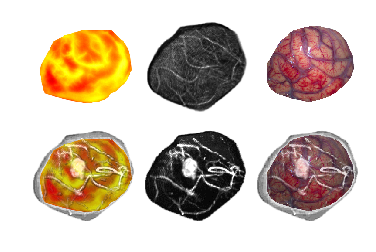

In [ ]:
grid = plt.GridSpec(2, 3, wspace=0.01, hspace=0.01)

plt.subplot(grid[0,0])
plt.imshow(thermo)
plt.axis('off')
#plt.title('Thermo')

plt.subplot(grid[0,1])
plt.imshow(mri_notumor,'gray')
plt.axis('off')
#plt.title('Rendered MRI')

plt.subplot(grid[0,2])
plt.imshow(optical)
plt.axis('off')
#plt.title('Optical')

plt.subplot(grid[1,0])
plt.imshow(fusion_thermal)
plt.axis('off')
#plt.title('Fused_thermal')

plt.subplot(grid[1,1])
plt.imshow(mri)
plt.axis('off')
#plt.title('Fused_optical')

plt.subplot(grid[1,2])
plt.imshow(fusion_opt)
plt.axis('off')
#plt.title('Fused_optical')